In [1]:
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd
import xarray as xr

plt.style.use("ggplot")

# Simulated discharge to the Arctic Ocean from greenland ice sheet melt

Data from Bamber et al. (2018; https://agupubs.onlinelibrary.wiley.com/doi/10.1002/2017JC013605). Monthly simulated fluxes to the Arctic Ocean from Greenland, Iceland, Svalbard, and areas around Canada. Focus on ice sheet and glacial melt, but also includes glacial calving and tundra runoff.

To do:
- Use the mask included in the netcdf to remove Iceland, Svalbard, etc. and just include Greenland
- Sum runoff_tundra and runoff_ice together, to get total runoff to the ocean.
- What to do with the solid_ice freshwater flux to the ocean? How big is this flux compared to the other two fluxes? If small, also just add to runoff_tundra and runoff_ice.
- Extrapolate to 2019 (just forward fill? Or if there's a trend since e.g. 2005, use that trend to predict future years?).
- Divide total summed discharge for the month by number of days in the month, to get mean monthly discharge.

## 1. Explore data

**Note:** The netCDF file is only 17 MB on disk, because compression is enabled and most of the values are zero. However, when read into memory it's more like 5 GB (see below), so **it's worth signing in on one of the larger machines** to work with this dataset.

In [2]:
nc_path = r"~/shared/pan_arctic_data/freshwater_flux_from_terrestrial_ice/bamber_2016/FWF17.v3_b.nc"
res_csv = r"~/shared/pan_arctic_data/freshwater_flux_from_terrestrial_ice/bamber_2016/greenland_discharge_tidy.csv"

In [3]:
# Open dataset and print metadata summary
ds = xr.open_dataset(nc_path)
print(f"Size in memory: {ds.nbytes / 1e9:.2f} GB.")
ds

Size in memory: 5.03 GB.


<xarray.Dataset>
Dimensions:              (Y: 785, X: 752, TIME: 708)
Coordinates:
  * Y                    (Y) float64 -6.731e+04 -7.231e+04 ... -3.987e+06
  * X                    (X) float64 -1.778e+06 -1.773e+06 ... 1.977e+06
  * TIME                 (TIME) datetime64[ns] 1958-01-01 ... 2016-12-01
Data variables:
    runoff_tundra        (TIME, Y, X) float32 ...
    lon                  (Y, X) float64 ...
    runoff_ice           (TIME, Y, X) float32 ...
    lat                  (Y, X) float64 ...
    polar_stereographic  int8 ...
    solid_ice            (TIME, Y, X) float32 ...
    LSMGr                (Y, X) float32 ...
    ocean_basins         (Y, X) float32 ...
Attributes:
    Conventions:  CF-1.4
    institution:  University of Bristol (Andrew Tedstone)
    title:        Monthly freshwater fluxes to the ocean across the Arctic, 1...
    nx:           752.0
    ny:           785.0
    xmin:         -1777980.0
    ymax:         -67308.0
    spacing:      5000.0
    description:  This is the dataset that underlies the paper "Bamber, J., A...

The dataset uses a custom stereographic projection, but also includes latitude and longitude co-ordinates, which are more easily transferable elsewhere. There are three main data variables (`runoff_tundra`, `runoff_ice` and `solid_ice`), all with units of km3 (per month), plus a boolean mask defining Greenland, which should make it easy to get just the Greenland data.

## 2. Extract basic data

The code below gets the Greenland mask, and also builds a data table mapping projected (`X` and `Y`) co-ordinates to longitude and latitude.

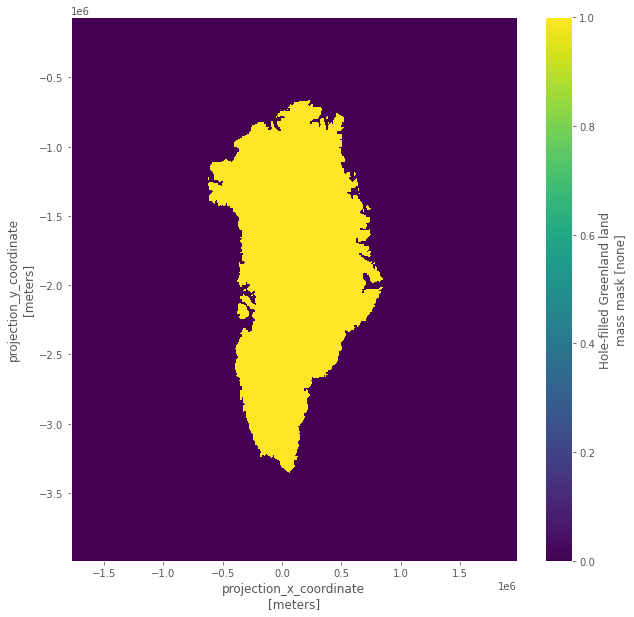

In [4]:
# Land mask for Greenland
gl_mask = ds["LSMGr"]
gl_mask.plot(figsize=(10, 10))

In [5]:
# Extract lat/lon values for Y/X co-ords to dataframes for use later
lon_df = ds["lon"].to_dataframe()
lat_df = ds["lat"].to_dataframe()
coord_df = pd.concat([lat_df, lon_df], axis="columns").reset_index()
coord_df.head()

,Y,X,lat,lon
0,-67308.110514,-1.777980e+06,73.681955,-132.832017
1,-67308.110514,-1.772980e+06,73.727188,-132.825909
2,-67308.110514,-1.767980e+06,73.772426,-132.819766
3,-67308.110514,-1.762980e+06,73.817668,-132.813589
4,-67308.110514,-1.757980e+06,73.862916,-132.807376


## 3. Extract Greenland data

The Greenland mask is equal to one within Greenland and zero elsewhere. Multiplying everything in the dataset by the Greenland mask will therefore set any values outside of Greenland to zero, while leaving the Greenland data unchanged. We can then extract all non-zero data from the dataset to get just the values for Greenland.

In [6]:
# Multiply all values in ds by Greenland mask.
# This sets runoff from all other areas to 0
ds = ds * gl_mask

In [7]:
# Loop over vars. Get just non-zero data and drop NaN. This is necessary to avoid
# the dataframe becoming huge
var_list = ["runoff_ice", "runoff_tundra", "solid_ice"]  # All in km3/month
idx_cols = ["lon", "lat", "date", "days_in_month"]
df_list = []
for var in var_list:
    df_list.append(ds[var].where(ds[var] != 0).to_dataframe().dropna())

df = pd.concat(df_list, axis="columns").reset_index().fillna(0)
df = pd.merge(df, coord_df, how="left", on=["X", "Y"])

# Tidy
df.rename({"TIME": "date",
           "runoff_ice": "runoff_ice_km3",
           "runoff_tundra": "runoff_tundra_km3",
           "solid_ice": "solid_ice_km3"},
          axis="columns", inplace=True)
df["days_in_month"] = df["date"].dt.days_in_month
df = df[idx_cols + var_list]
df.sort_values(idx_cols, inplace=True)
df.reset_index(inplace=True, drop=True)

# Add total runoff per month (km3/month)
df["runoff_total_km3"] = df["runoff_ice"] + df["runoff_tundra"] + df["solid_ice"]

# Save
print(f"Size in memory: {df.memory_usage(index=True).sum() / 1e6:.2f} MB.")
df.to_csv(res_csv, index=False)
df.head()

Size in memory: 23.81 MB.


,lon,lat,date,days_in_month,runoff_ice,runoff_tundra,solid_ice,runoff_total,runoff_total_Mm3/day
0,-72.931712,78.157519,1958-07-01,31,0.0,0.02,0.0,0.02,0.645161
1,-72.931712,78.157519,1958-08-01,31,0.0,0.01,0.0,0.01,0.322581
2,-72.931712,78.157519,1959-06-01,30,0.0,0.01,0.0,0.01,0.333333
3,-72.931712,78.157519,1959-07-01,31,0.0,0.02,0.0,0.02,0.645161
4,-72.931712,78.157519,1959-08-01,31,0.0,0.01,0.0,0.01,0.322581


In [8]:
# Get unique co-ordinates and plot to check
gl_pts_df = df[["lon", "lat"]].drop_duplicates().reset_index(drop=True)
nivapy.spatial.quickmap(gl_pts_df, lon_col="lon", lat_col="lat")

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>], dtype=object)

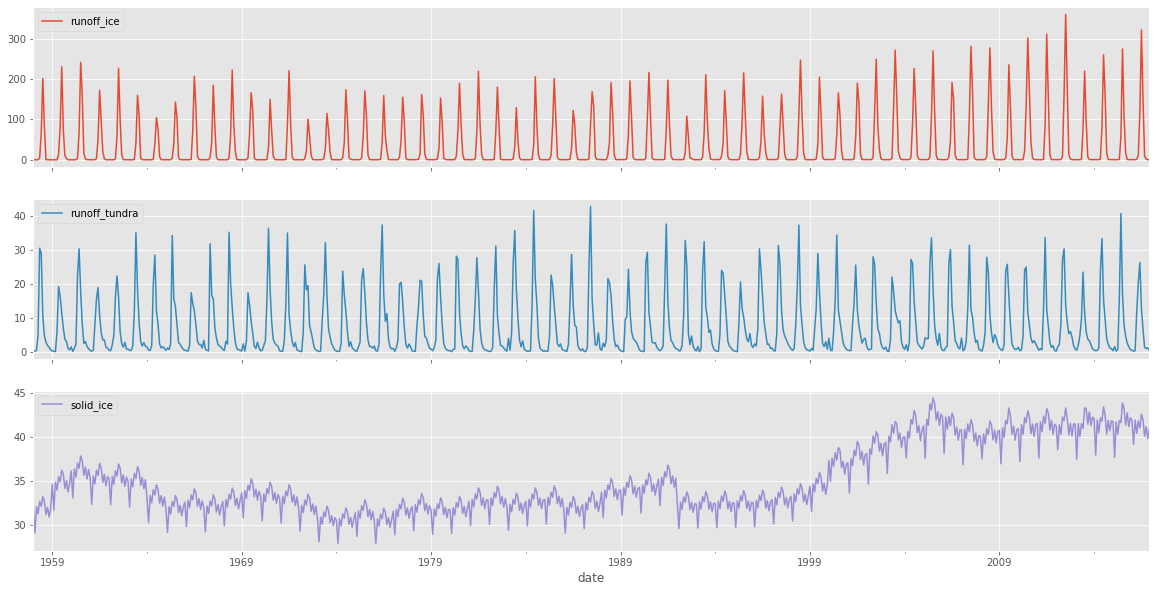

In [9]:
# Plot monthly totals for the whole of Greenland
df.groupby("date").sum()[var_list].plot(figsize=(20, 10), subplots=True)

## 4. Filling data gaps (optional)

Results so far only include dates and locations where at least one variable is non-zero. This is sensible, as melting mostly only takes place in the summer and there's no point storing thousands of additional rows that are all zero. It also works OK for plotting in Pandas (see above) as lines are drawn over the missing values. However, for completeness, it's useful to be able to generate a dataset with a complete list of dates for each pair of co-ordinates (even if most of the values will be zero). This is done below. Note that this creates a much larger CSV, which mostly consists of zeros. There therefore doesn't seem much point saving it in this format at this stage.

In [10]:
# Build empty dataframe with full range of dates for each location
# freq="MS" => use first day of each month, rather than last
dates = pd.date_range("1958-01-01", "2016-12-31", freq="MS")
df_list = []
for idx, row in gl_pts_df.iterrows():
    df_list.append(pd.DataFrame({"lon": row["lon"], "lat": row["lat"]}, index=dates))

all_df = pd.concat(df_list, axis="rows").reset_index()
all_df.rename({"index": "date"}, axis="columns", inplace=True)
all_df["days_in_month"] = all_df["date"].dt.days_in_month
all_df = pd.merge(all_df, df, how="left", on=idx_cols).fillna(0)
all_df.sort_values(idx_cols, inplace=True)
print(f"Size in memory: {all_df.memory_usage(index=True).sum() / 1e6:.2f} MB.")
all_df.head()

Size in memory: 108.79 MB.


,date,lon,lat,days_in_month,runoff_ice,runoff_tundra,solid_ice,runoff_total,runoff_total_Mm3/day
0,1958-01-01,-72.931712,78.157519,31,0.0,0.0,0.0,0.0,0.0
1,1958-02-01,-72.931712,78.157519,28,0.0,0.0,0.0,0.0,0.0
2,1958-03-01,-72.931712,78.157519,31,0.0,0.0,0.0,0.0,0.0
3,1958-04-01,-72.931712,78.157519,30,0.0,0.0,0.0,0.0,0.0
4,1958-05-01,-72.931712,78.157519,31,0.0,0.0,0.0,0.0,0.0
